In [1]:
import math

import ConnectionNetworkX as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Initialize the grid graph

[5.52660284e-02 2.82797759e-02 2.82797759e-02 2.82797759e-02
 2.82797759e-02 2.82797759e-02 2.82797759e-02 1.52171378e-15
 6.17622331e-16 2.20995694e-16]
MOST LIKELY CONSISTENT: |lambda_min| < 1e-8. 


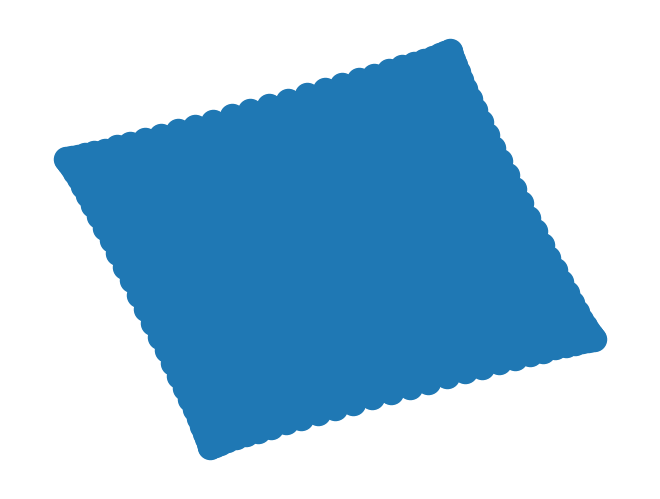

In [2]:

GRID_WIDTH = 32
GRID_HEIGHT = 32
INTRINSIC_DIM = 3

ADD_ROTATIONAL_PERTURBATION = False
THETA = math.pi / 2

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

if ADD_ROTATIONAL_PERTURBATION:
    r = np.array([[math.cos(THETA), -math.sin(THETA)], [math.sin(THETA), math.cos(THETA)]])
    gridGraph.updateEdgeSignature((0,1), r)

gridGraph.printConnectionLaplacianEigenvalues()
nx.draw_spectral(gridGraph)

gridGraphIncidenceMatrix = gridGraph.connectionIncidenceMatrix


Generate the constraint matrices and densities to be transported. Example seen here is dirac densities at corners of the grid.

In [3]:
import torch

FROM_NODE_INDEX = 0
TO_NODE_INDEX = 35

mu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]
nu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]

mu[ (FROM_NODE_INDEX * INTRINSIC_DIM) : ((FROM_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1
nu[ (TO_NODE_INDEX * INTRINSIC_DIM) : ((TO_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1

c = mu - nu
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.ones(B.T.shape[0]//INTRINSIC_DIM).astype('float32'))
c = torch.tensor(c)

# L2 least squares
#leastSquarePrimal, _, _, _ = np.linalg.lstsq(B.detach().numpy(), c.detach().numpy())
initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)

#c_sol1 = active_edges(c_sol, B, w, c)
#c_sol1 = c_sol.detach().numpy()
#print(c_sol1)


100%|██████████| 1024/1024 [00:01<00:00, 779.13it/s]


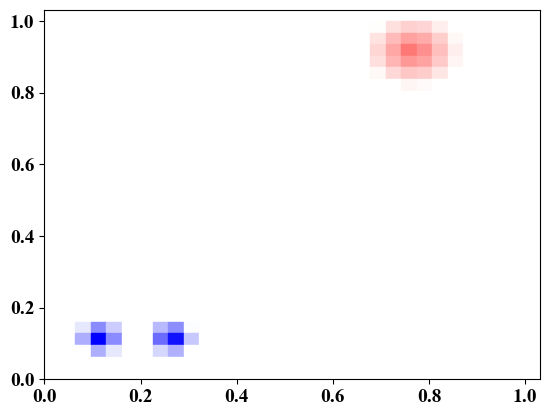

In [4]:
def localizedColorDensity(grid, centerInEmbeddingSpace, normalizedRGBValues, radiusInCanonicalEmbeddingSpace):

    RGB_DIM = 3

    x0, y0 = centerInEmbeddingSpace

    density = np.zeros((gridGraph.nNodes, RGB_DIM))#.flatten()[:,None]

    # In order for it to be a valid density we need to add some ambient color so the row sum is positive everywhere
    uniformNoise = (1 - normalizedRGBValues) / grid.nNodes

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]

        d = ((x - x0) ** 2 + (y - y0) ** 2) ** 0.5

        if d <= radiusInCanonicalEmbeddingSpace:
            #alpha = math.exp(- math.log(4) * d / radiusInCanonicalEmbeddingSpace)
            alpha = 1 - d / radiusInCanonicalEmbeddingSpace
            scaledRGB = (alpha) * normalizedRGBValues
        else:
            scaledRGB = np.array([0, 0, 0])

        density[node, :] = scaledRGB + uniformNoise

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def renderColorDensityAsImage(grid, localizedColorDensity):

    fig, ax = plt.subplots()
    embedding = grid.gridEmbedding
    RGB_DIM = 3

    ax.set_xlim((0, 1 + 1/GRID_WIDTH))
    ax.set_ylim((0, 1 + 1/GRID_HEIGHT))

    for node in tqdm(list(range(gridGraph.nNodes))):

        INTENSITY = 1 / np.max(localizedColorDensity)

        center = embedding[node][0], embedding[node][1]
        colorRGB = (1 - INTENSITY*localizedColorDensity[(node * RGB_DIM) : ((node + 1) * RGB_DIM)]).tolist() + [1]

        nodeLabel = matplotlib.patches.Rectangle(center, 1/GRID_WIDTH, 1/GRID_HEIGHT, color=colorRGB)
        ax.add_patch(nodeLabel)

    plt.show()

densityColorM = np.array([1, 1, 0])
m0 = localizedColorDensity(gridGraph, (0.1, 0.1), densityColorM, .05)
m1 = localizedColorDensity(gridGraph, (0.25, 0.1), densityColorM, .05)

m = 0.5 * (m0 + m1)

densityColorN = np.array([0, 1, 1])
n = localizedColorDensity(gridGraph, (0.75, 0.9), densityColorN, .1)

renderColorDensityAsImage(gridGraph, m + n)

c = m - n
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))
c = torch.tensor(c)

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.ones(B.T.shape[0]//INTRINSIC_DIM).astype('float32'))

initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)


In [5]:
learning_rate = 0.1
alpha = 1
n_epochs = 1000

gridPhi = cnx.optimize(B.T, w, c, alpha, learning_rate, n_epochs, phi0=initialPhi)

/Users/sawyerjack/IdeaProjects/connection-graph-wasserstein/ConnectionNetworkX.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


epoch: 0, loss: 0.911177, loss0: 0.911177, loss1: 0.000000
epoch: 10, loss: -4.025893, loss0: -4.053805, loss1: 0.055823
epoch: 20, loss: -7.369208, loss0: -7.539026, loss1: 0.339637
epoch: 30, loss: -10.473475, loss0: -10.608880, loss1: 0.270809
epoch: 40, loss: -13.081503, loss0: -13.213746, loss1: 0.264486
epoch: 50, loss: -15.357226, loss0: -15.478974, loss1: 0.243497
epoch: 60, loss: -17.296508, loss0: -17.503940, loss1: 0.414865
epoch: 70, loss: -19.098817, loss0: -19.212277, loss1: 0.226920
epoch: 80, loss: -20.317735, loss0: -20.701324, loss1: 0.767179
epoch: 90, loss: -21.726900, loss0: -21.953822, loss1: 0.453844
epoch: 100, loss: -22.837731, loss0: -23.072984, loss1: 0.470507
epoch: 110, loss: -23.901608, loss0: -24.061122, loss1: 0.319027
epoch: 120, loss: -24.855774, loss0: -25.024278, loss1: 0.337007
epoch: 130, loss: -25.740620, loss0: -25.928759, loss1: 0.376278
epoch: 140, loss: -26.622767, loss0: -26.796423, loss1: 0.347311
epoch: 150, loss: -27.448716, loss0: -27.677

# Visualizing the Soln. to the Connection Beckmann Problem on a Grid

100%|██████████| 1024/1024 [00:04<00:00, 210.37it/s]


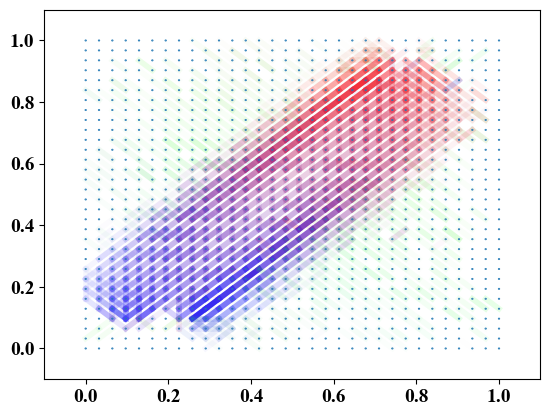

In [6]:

regularizedActiveEdges = cnx.active_edges(gridPhi, B.T, w, c).detach().numpy()
regularizedEdgeFlows = torch.matmul(B.T, gridPhi).detach().numpy()

spectralEmbedding = gridGraph.gridEmbedding

TOLERANCE = 0
MAX = np.max(regularizedActiveEdges)

fig, ax = plt.subplots()
ax.set_xlim((-.1, 1.1))
ax.set_ylim((-.1, 1.1))

for node in tqdm(list(range(gridGraph.nNodes))):
    center = spectralEmbedding[node][0], spectralEmbedding[node][1]
    # if node in [FROM_NODE_INDEX, TO_NODE_INDEX]:
    #     col="tab:red"
    #     zNode=4
    #     r=2e-2
    #      #ax.text(center[0], center[1], str(node+1))
    # else:
    # phi = gridPhi.detach().numpy()
    col = "tab:blue" # phi[(node * INTRINSIC_DIM) : ((node + 1) * INTRINSIC_DIM) ].tolist() + [1]  #"tab:blue"
    zNode=4
    r=1e-3
    nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    ax.add_patch(nodeLabel)

for edgeIndex, edge in zip(range(gridGraph.nEdges), list(gridGraph.edges())):

    flow = regularizedEdgeFlows[(edgeIndex * INTRINSIC_DIM) : ((edgeIndex + 1) * INTRINSIC_DIM) ]
    #col = gridPhi[(edge[0] * INTRINSIC_DIM) : ((edge[0] + 1) * INTRINSIC_DIM) ]

    flow = [1+x if x < 0 else 1 - x for x in flow] #1 + x

    if regularizedActiveEdges[edgeIndex] > TOLERANCE:
        alpha = abs(regularizedActiveEdges[edgeIndex])/MAX
        col= flow + [alpha] #(1, 0, .1, abs(regularizedActiveEdges[edgeIndex])/MAX)
        z = 3
        lw = 4
    else:
        #col="tab:blue"
        lw=0.5
        col=(1,1,1,0)
        z = 3

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=lw)

plt.show()

# xData, yData = spectralEmbedding.values


In [7]:
regularizedActiveEdges

array([-0.67364588, -0.72458988, -0.73034941, ..., -0.20358617,
       -0.35250726, -0.17396861])